In [40]:
import json

with open('/home/steohan/ma/thesis/benchresults/incphp/sat-paper-run1.json', 'r') as jsonFile:
    config = json.loads(jsonFile.read())

In [41]:
confIds = dict()
for experiment in config["runResults"]:
    conf = json.dumps(experiment["conf"]["setup"], indent=4)
    confId = hash(conf)
    confIds[confId] = conf

In [42]:
import math


def computeName(x):
    name = ''
    if (x['conf.setup.incremental']):
        name += 'incr. '    
    if x['conf.setup.variant.3sat']:
        name += '3SAT '
    if x['conf.setup.variant.addAssumed']:
        name += 'addAssumed '
    if x['conf.setup.variant.alternate']:
        name += 'alternate '
    if x['conf.setup.variant.extendedResolution']:
        name += 'extended '
    if x['conf.setup.record']:
        name += 'recording '
    if name == '':
        name = 'normal'
    return name

In [43]:
from pandas.io.json import json_normalize
import pandas

df = json_normalize(config["runResults"])
toFillNan = [
    "incphp.result.executionTime.userTime",
    "incphp.result.executionTime.systemTime",
    "incphp.result.executionTime.returnCode"
]

df[toFillNan] = df[toFillNan].fillna(value=0.0)
df = df.assign(
    time = lambda x: 
        x["incphp.result.executionTime.userTime"]
        + x["incphp.result.executionTime.systemTime"],
    error = lambda x: 
        (x["incphp.result.executionTime.returnCode"] != 0),
    confId = [hash(json.dumps(experiment["conf"]["setup"], indent=4)) for experiment in config["runResults"]]
)
df = df.assign(name = lambda x: x.apply(computeName, axis = 1))

In [44]:
list(df)

['%limits.RLIMIT_AS',
 '%limits.RLIMIT_CPU',
 'conf.numPigeons',
 'conf.run',
 'conf.setup.incremental',
 'conf.setup.record',
 'conf.setup.solver',
 'conf.setup.variant.3sat',
 'conf.setup.variant.addAssumed',
 'conf.setup.variant.alternate',
 'conf.setup.variant.extendedResolution',
 'incphp.parameters.3sat',
 'incphp.parameters.addAssumed',
 'incphp.parameters.alternate',
 'incphp.parameters.binDir',
 'incphp.parameters.dimspec',
 'incphp.parameters.extendedResolution',
 'incphp.parameters.incremental',
 'incphp.parameters.numPigeons',
 'incphp.parameters.print',
 'incphp.parameters.record',
 'incphp.parameters.solver',
 'incphp.result.executionTime.returnCode',
 'incphp.result.executionTime.systemTime',
 'incphp.result.executionTime.userTime',
 'incphp.result.executionTime.wallClockTime',
 'incphp.result.learnedClauseEval.numLearnedClauses',
 'incphp.result.learnedClauseEval.numLearnedClausesWithAssumedLiteral',
 'incphp.result.learnedClauseEval.numSolvesWithAssumption',
 'incphp.r

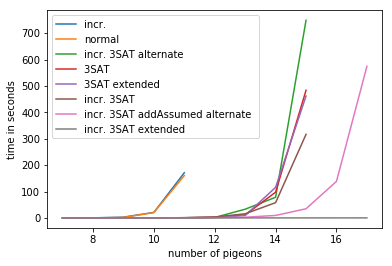

In [195]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == False)
    & (
        (df['incphp.parameters.alternate'] == False)
      | (
         (df['conf.setup.incremental'] == True)
        )
      )
    & (df['conf.numPigeons'] > 6)
]

plots = list()
for confId, data in d.groupby("confId"):
    name = data.iloc[0]["name"]
    points = list()
    maxPigeon = 0
    maxTime = 0
    for numPigeons, data in data.groupby('conf.numPigeons'):
        if (len(data["time"].values) > 3):
            points.append((
                numPigeons,
                statistics.mean(data["time"].values)
            ))
            if (numPigeons > maxPigeon):
                maxPigeon = numPigeons
                maxTime = statistics.mean(data["time"].values)
    plots.append(((maxPigeon, -maxTime), name, points))

for _, name, points in sorted(plots):
    plt.plot(*zip(*points), label=name)

plt.xlabel("number of pigeons")
plt.ylabel("time in seconds")
#plt.semilogy()
plt.legend()
plt.show()

In [190]:
sorted([((2,4), "zwa"),((2,3), "a")])

[((2, 3), 'a'), ((2, 4), 'zwa')]

In [65]:
inc = sorted(df[
      (df['conf.setup.incremental'] == True)
    & (df['conf.setup.record'] == False)
    & (df['conf.setup.variant.3sat'] == True)
    & (df['conf.setup.variant.addAssumed'] == False)
    & (df['conf.setup.variant.alternate'] == False)
    & (df['conf.setup.variant.extendedResolution'] == False)
    & (df['conf.numPigeons'] == 15)
]["time"].values)

normal = sorted(df[
      (df['conf.setup.incremental'] == False)
    & (df['conf.setup.record'] == False)
    & (df['conf.setup.variant.3sat'] == True)
    & (df['conf.setup.variant.addAssumed'] == False)
    & (df['conf.setup.variant.alternate'] == False)
    & (df['conf.setup.variant.extendedResolution'] == False)
    & (df['conf.numPigeons'] == 15)
]["time"].values)

print(statistics.mean(inc), statistics.median(inc), statistics.stdev(inc))
print(statistics.stdev(normal))
list(zip(inc,normal))

316.7012 270.17 160.29073912446307
141.18690414813082


[(115.50399999999985, 404.43599999999873),
 (159.35200000000071, 410.03200000000055),
 (182.54399999999981, 452.1200000000008),
 (219.83600000000027, 483.3399999999998),
 (234.72799999999947, 488.55599999999924),
 (305.61200000000008, 494.67200000000048),
 (416.75999999999902, 512.79200000000037),
 (444.00800000000163, 552.69199999999967),
 (513.32399999999893, 554.01999999999987),
 (575.34400000000073, 899.96400000000165)]

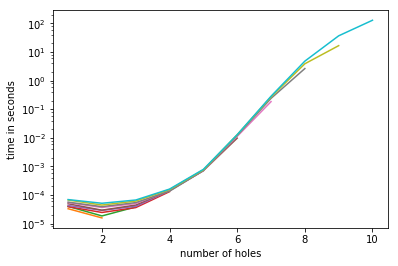

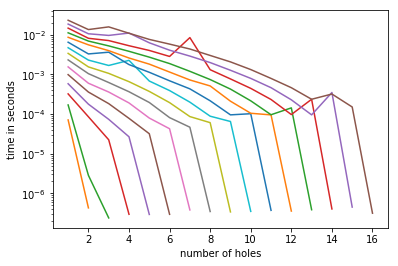

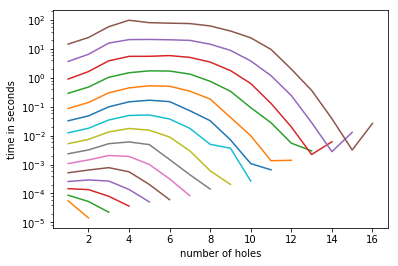

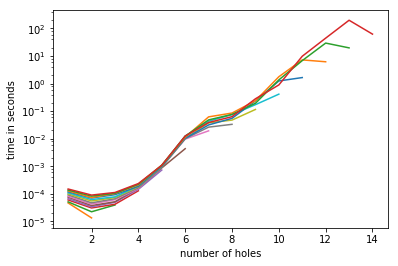

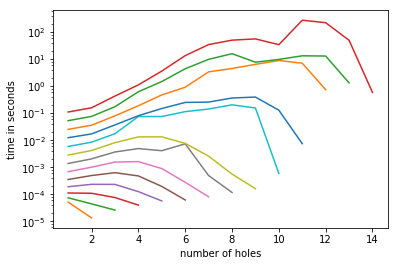

In [159]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == False)
    & (df['conf.setup.incremental'] == True)
   #& (df['conf.numPigeons'] > 12)
   #& (df['conf.setup.variant.addAssumed'] == False)
]

for confId, data in d.groupby("confId"):
    for numPigeons, data in data.groupby('conf.numPigeons'):
        name = data.iloc[0]["name"]
        name += " - " + str(numPigeons)
        pts = dict()
        for idx, dat in data.iterrows():
            for row in dat['incphp.result.solves']:
                lst =  pts.get(row['makespan'], list())
                lst.append(row['time'])
                pts[row['makespan']] = lst

        points = list()
        for ms, times in pts.items():
            if len(times) > 3:
                points.append((ms, statistics.mean(times)))
        plt.xlabel("number of holes")
        plt.ylabel("time in seconds")
        plt.plot(*zip(*points), label=name)

    plt.semilogy()
    #plt.legend(bbox_to_anchor=(2,1))
    plt.show()

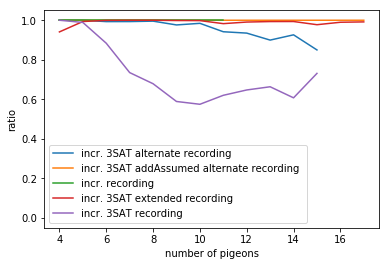

In [183]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == True)
    & (df['conf.setup.incremental'] == True)
    & (df['conf.numPigeons'] > 3)
]

for confId, data in d.groupby("confId"):
    name = data.iloc[0]["name"]
    points = list()
    for numPigeons, data in data.groupby('conf.numPigeons'):
        score = list()
        for idx, dat in data.iterrows():
            for row in dat['incphp.result.solves']:
                if (row['makespan'] == numPigeons - 2):
                    score.append(
                        row['numLearnedClausesWithAssumedLiteral'] /
                        row['numLearnedClauses']
                    )
#        nlc = data['incphp.result.learnedClauseEval.numLearnedClauses'].values
#        nlcwal = data['incphp.result.learnedClauseEval.numLearnedClausesWithAssumedLiteral'].values
#        score = list(map(lambda x: x[0]/x[1], zip(nlcwal, nlc)))
        
        if (len(score) > 3):
            points.append((
                numPigeons,
                statistics.mean(score)
            ))
    ax = plt.gca()
    ax.set_ylim([-0.05,1.05])
    plt.xlabel("number of pigeons")
    plt.ylabel("ratio")
    plt.plot(*zip(*points), label=name)

#plt.semilogy()
plt.legend()
plt.show()

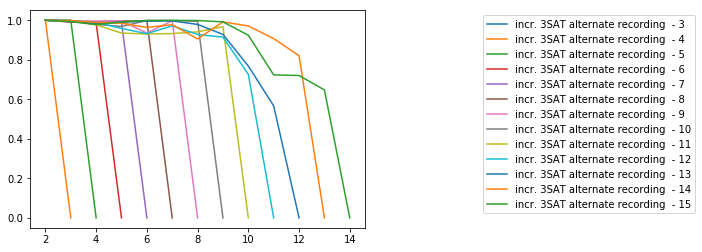

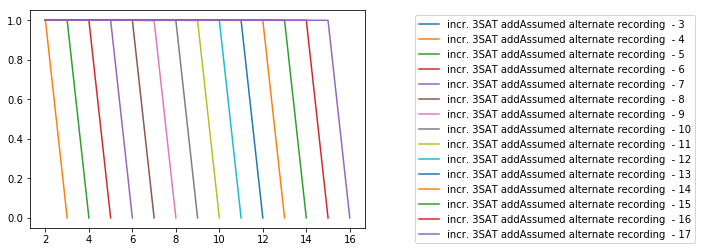

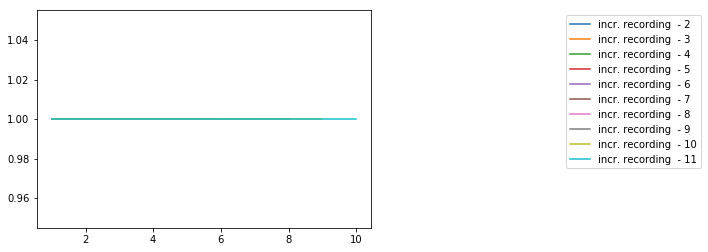

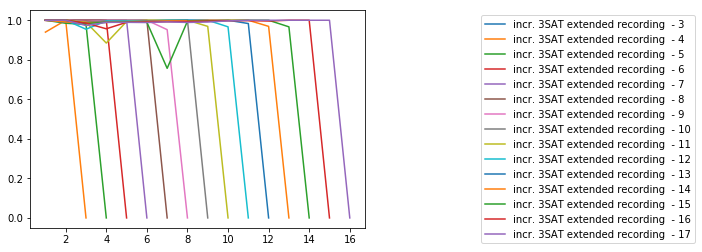

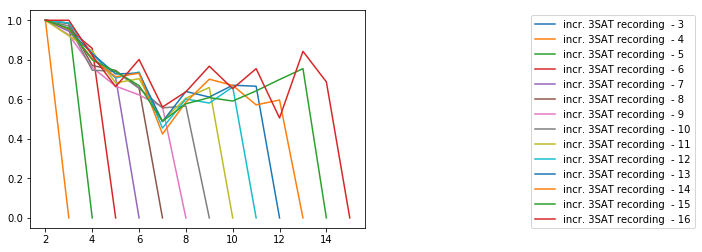

In [139]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == True)
    & (df['conf.setup.incremental'] == True)
   #& (df['conf.setup.variant.3sat'] == False)
   #& (df['conf.numPigeons'] > 12)
   #& (df['conf.setup.variant.addAssumed'] == False)
]

for confId, data in d.groupby("confId"):
    for numPigeons, data in data.groupby('conf.numPigeons'):
        name = data.iloc[0]["name"]
        name += " - " + str(numPigeons)
        nlc = dict()
        nlcwal = dict()
        pts = dict()
        for idx, dat in data.iterrows():
            lpts = dict()
            for row in dat['incphp.result.solves']:
                nlc[row['makespan']] = row['numLearnedClauses']
                nlcwal[row['makespan']] = row['numLearnedClausesWithAssumedLiteral']

            for i in reversed(sorted(nlc.keys())):
                if (i != 1):
                    nlc[i] = nlc[i] - nlc[i - 1]
                    nlcwal[i] = nlcwal[i] - nlcwal[i - 1]

            for i in reversed(sorted(nlc.keys())):
                lst =  pts.get(i, list())
                if nlc[i] > 0:
                    lst.append(nlcwal[i] / nlc[i])
                    pts[i] = lst

        points = list()
        for i in reversed(sorted(pts.keys())):
            if len(score) > 3:
                points.append((i, statistics.mean(pts[i])))
        
        plt.plot(*zip(*points), label=name)

    #plt.semilogy()
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

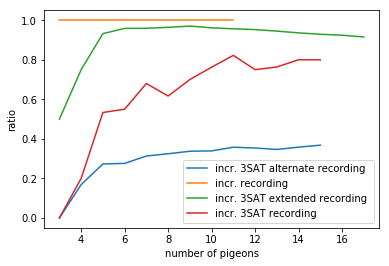

In [196]:
 'incphp.result.learnedClauseEval.numSolvesWithAssumption'
 'incphp.result.learnedClauseEval.numSolvesWithAssumptionFound'
 'incphp.result.learnedClauseEval.numSolvesWithSubsetAssumptionFound'

import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == True)
    & (df['conf.setup.incremental'] == True)
    & (df['conf.numPigeons'] > 1)
    & (df['incphp.parameters.addAssumed'] == False)
]

for confId, data in d.groupby("confId"):
    name = data.iloc[0]["name"]
    points = list()
    for numPigeons, data in data.groupby('conf.numPigeons'):
        score = list()
        for idx, dat in data.iterrows():
            for row in dat['incphp.result.solves']:
                if (row['makespan'] == numPigeons - 2):
                    score.append(
                        row['numSolvesWithSubsetAssumptionFound'] /
                        row['numSolvesWithAssumption']
                    )
#        nlc = data['incphp.result.learnedClauseEval.numLearnedClauses'].values
#        nlcwal = data['incphp.result.learnedClauseEval.numLearnedClausesWithAssumedLiteral'].values
#        score = list(map(lambda x: x[0]/x[1], zip(nlcwal, nlc)))
        
        if (len(score) > 3):
            points.append((
                numPigeons,
                statistics.mean(score)
            ))

    plt.plot(*zip(*points), label=name)
    
plt.xlabel("number of pigeons")
plt.ylabel("ratio")
#plt.semilogy()
plt.legend()
plt.show()

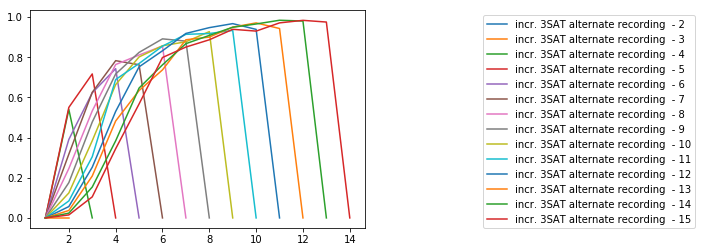

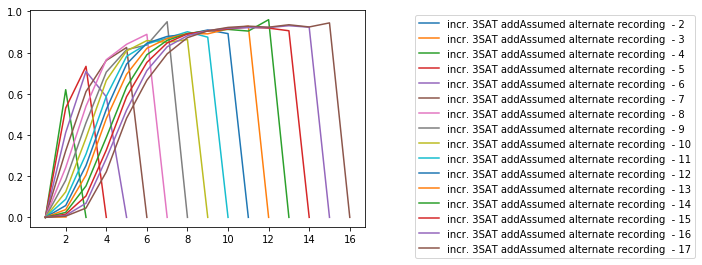

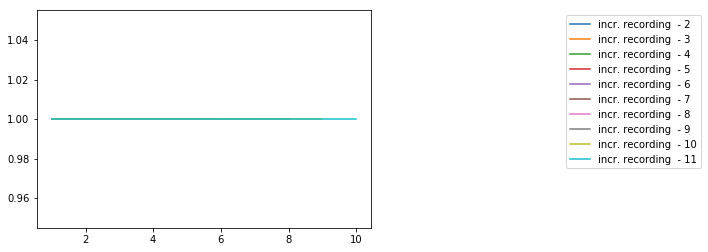

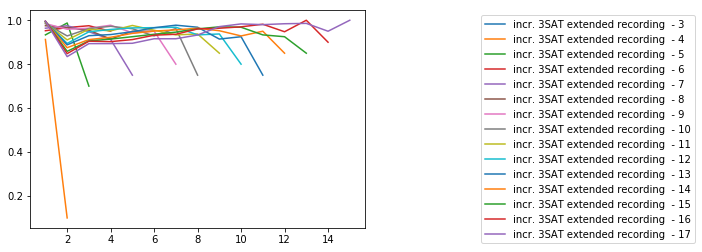

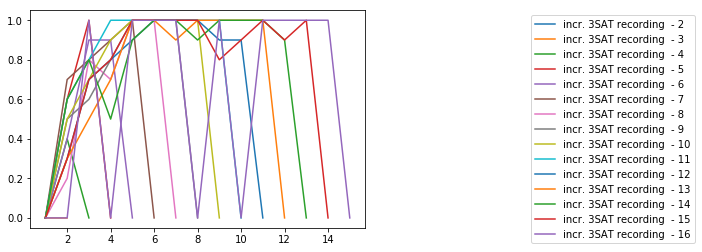

In [138]:
import matplotlib.pyplot as plt
import statistics

d = df[
      (df['error'] == False)
    & (df['conf.setup.record'] == True)
    & (df['conf.setup.incremental'] == True)
   #& (df['conf.setup.variant.3sat'] == False)
   #& (df['conf.numPigeons'] > 12)
   #& (df['conf.setup.variant.addAssumed'] == False)
]

for confId, data in d.groupby("confId"):
    for numPigeons, data in data.groupby('conf.numPigeons'):
        name = data.iloc[0]["name"]
        name += " - " + str(numPigeons)
        nlc = dict()
        nlcwal = dict()
        pts = dict()
        for idx, dat in data.iterrows():
            lpts = dict()
            for row in dat['incphp.result.solves']:
                nlc[row['makespan']] = row['numSolvesWithAssumption']
                nlcwal[row['makespan']] = row['numSolvesWithSubsetAssumptionFound']

            for i in reversed(sorted(nlc.keys())):
                if (i != 1):
                    nlc[i] = nlc[i] - nlc[i - 1]
                    nlcwal[i] = nlcwal[i] - nlcwal[i - 1]

            for i in reversed(sorted(nlc.keys())):
                lst =  pts.get(i, list())
                if nlc[i] > 0:
                    lst.append(nlcwal[i] / nlc[i])
                    pts[i] = lst

        points = list()
        for i in reversed(sorted(pts.keys())):
            if len(score) > 3:
                points.append((i, statistics.mean(pts[i])))
        
        plt.plot(*zip(*points), label=name)

    #plt.semilogy()
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()